# 1. Librairie Gym 

Gym est une librairie Python développée par OpenAI pour créer et tester des environnements 
d'apprentissage par renforcement (reinforcement learning). 

Caractéristiques principales:
- Fournit une collection d'environnements de simulation standardisés
- Compatible avec de nombreux algorithmes d'RL (Q-learning, policy gradient, etc.)
- Facilite le benchmarking et la comparaison de différents agents
- Inclut des environnements classiques (CartPole, MountainCar, Atari, etc.)
- API simple et cohérente pour interagir avec les environnements
- Permet de créer des environnements personnalisés

https://gymnasium.farama.org/

# 2. Environnement FrozenLake

FrozenLake est un environnement classique de Gym qui simule un lac gelé avec des trous.

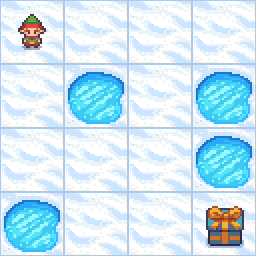

## Description de l'environnement FrozenLake

FrozenLake est un environnement simple de grille 4x4 où:

**Objectif:** 
L'agent doit naviguer du point de départ (S) jusqu'à l'objectif (G) en évitant les trous (H).

**État:**
- Grille de 4x4 avec 16 positions possibles
- Position actuelle de l'agent (0-15)

**Actions:**
L'agent peut se déplacer dans 4 directions:
- 0: Gauche
- 1: Bas
- 2: Droite
- 3: Haut

**Récompenses:**
- +1 si l'agent atteint l'objectif (G)
- 0 sinon

**Terminalisation:**
L'épisode se termine si:
- L'agent atteint l'objectif (succès)
- L'agent tombe dans un trou (échec)
- Nombre maximum d'étapes atteint

**Caractéristiques:**
- Environnement stochastique: le mouvement peut être aléatoire (glissance sur la glace)
- Parfait pour tester les algorithmes basiques de reinforcement learning
- Permet de démontrer Q-learning, policy gradient et autres méthodes RL

In [14]:
import gymnasium as gym
env = gym.make('FrozenLake-v1')

env.unwrapped.P[6][2]

[(0.33333333333333337, 10, 0, False),
 (0.3333333333333333, 7, 0, True),
 (0.33333333333333337, 2, 0, False)]

## Résolution du MDP FrozenLake avec la policy itérative


In [15]:
import numpy as np

def compute_q_value_s_a(env, V, s, a, gamma):
    q_sa = 0
    for p, s_prime, r, done in env.unwrapped.P[s][a]:
        q_sa += p*(r + gamma*V[s_prime])
    return float(q_sa)

In [16]:
import numpy as np

def policy_evaluation(env, pi, V, gamma=0.99, theta=1e-8, max_iter=10_000):
    """
    Évalue une politique pi en calculant V_pi via des mises à jour itératives (Bellman expectation backup).

    Paramètres
    ----------
    env : environnement (discret)
        Doit exposer env.nS (nb d'états), env.nA (nb d'actions), et la dynamique utilisée
        par compute_q_value_s_a(...).
    pi : array-like, shape (nS, nA)
        Politique stochastique : pi[s][a] = P(a|s).
    V : np.ndarray, shape (nS,)
        Valeur d'état initiale. Modifiée en place et aussi renvoyée.
    gamma : float
        Facteur d'actualisation.
    theta : float
        Seuil de convergence (norme infinie sur la variation de V).
    max_iter : int
        Garde-fou pour éviter une boucle infinie si problème de convergence.

    Retour
    ------
    V : np.ndarray
        Estimation de V_pi.
    n_iter : int
        Nombre d'itérations effectuées.
    """
    V = np.asarray(V, dtype=float)  # assure le type float
    pi = np.asarray(pi, dtype=float)

    for n_iter in range(1, max_iter + 1):
        delta = 0.0

        for s in range(env.observation_space.n):
            v_old = V[s]

            v_new = 0.0
            for a in range(env.action_space.n):
                prob_a = pi[s, a]
                q_sa = compute_q_value_s_a(env, V, s, a, gamma)
                v_new += prob_a * q_sa

            delta = max(delta, abs(v_new - v_old)) 
            V[s] = v_new

        # Critère de convergence
        if delta < theta:
            return V, n_iter

    # Si on sort ici, on n'a pas convergé dans max_iter itérations
    return V, n_iter

def policy_improvement(env, V, gamma=0.9):
    """
    Améliore une politique à partir d'une fonction de valeur V (greedy policy improvement).

    Retour
    ------
    pi_new : np.ndarray, shape (nS, nA)
        Politique déterministe greedy : pi_new[s, a*] = 1 pour l'action a* argmax_a Q(s,a).
    """
    pi_new = np.zeros((env.observation_space.n, env.action_space.n), dtype=float)

    for s in range(env.observation_space.n):
        # Calcule tous les Q(s,a) pour l'état s
        q_values = np.zeros(env.action_space.n, dtype=float)
        for a in range(env.action_space.n):
            q_values[a] = compute_q_value_s_a(env, V, s, a, gamma)

        best_a = int(np.argmax(q_values))
        # Politique déterministe: 1 sur best_a, 0 ailleurs
        pi_new[s, best_a] = 1.0

    return pi_new


In [17]:
import numpy as np

def policy_iteration(env, V=None, pi=None, gamma=0.99, theta=1e-8, max_iter=10_000):
    """
    Policy Iteration (itération sur les politiques) :
    1) Policy Evaluation : calcule V^{pi}
    2) Policy Improvement : pi <- greedy(V^{pi})
    Jusqu'à stabilité de la politique.

    Paramètres
    ----------
    env : env discret 
    V : np.ndarray (nS,) ou None
        Valeur initiale. Si None -> vecteur de zéros.
    pi : np.ndarray (nS,nA) ou None
        Politique initiale (stochastique). Si None -> uniforme.
    gamma : float
        Discount.
    theta : float
        Seuil de stabilité de la politique (on compare old_pi vs new_pi).
    max_iter : int
        Nombre max d'itérations de policy iteration.

    Retour
    ------
    V : np.ndarray (nS,)
    pi : np.ndarray (nS,nA)
    n_outer : int (nombre d'itérations externes)
    """
    # Initialisations robustes
    if V is None:
        V = np.zeros(env.observation_space.n, dtype=float)
    else:
        V = np.asarray(V, dtype=float)

    if pi is None:
        pi = np.ones((env.observation_space.n, env.action_space.n), dtype=float) / env.action_space.n
    else:
        pi = np.asarray(pi, dtype=float)


    for n_outer in range(1, max_iter + 1):
        old_pi = pi.copy() 

        # 1) Évaluation de la politique courante
        V, _ = policy_evaluation(env, old_pi, V, gamma=gamma, theta=theta)

        # 2) Amélioration (politique greedy)
        pi = policy_improvement(env, V, gamma=gamma)

        # 3) Test de stabilité de la politique
        delta = np.max(np.abs(pi - old_pi))

        if delta < theta:
            return V, pi, n_outer

    return V, pi, n_outer


V_star, pi_star, n = policy_iteration(env)
print(V_star, pi_star, n)

    

[0.54202581 0.49880303 0.4706955  0.4568515  0.55845085 0.
 0.35834799 0.         0.59179866 0.64307976 0.6152075  0.
 0.         0.7417204  0.86283741 0.        ] [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] 3


## Résolution du MDP FrozenLake avec Value Iteration

In [18]:
import numpy as np
import gymnasium as gym 

env = gym.make('FrozenLake-v1')

V = np.zeros([env.observation_space.n, 1])
gamma = 0.99
theta =0.00001

In [19]:
def compute_q_value_s_a(env, V, s, a, gamma):
    q_sa = 0
    for p, s_prime, r, done in env.unwrapped.P[s][a]:
        q_sa += p*(r + gamma*V[s_prime])
    return float(q_sa)

In [20]:
def policy_improvement(env, V, gamma=0.9):
    """
    Améliore une politique à partir d'une fonction de valeur V (greedy policy improvement).

    Retour
    ------
    pi_new : np.ndarray, shape (nS, nA)
        Politique déterministe greedy : pi_new[s, a*] = 1 pour l'action a* argmax_a Q(s,a).
    """
    pi_new = np.zeros((env.observation_space.n, env.action_space.n), dtype=float)

    for s in range(env.observation_space.n):
        # Calcule tous les Q(s,a) pour l'état s
        q_values = np.zeros(env.action_space.n, dtype=float)
        for a in range(env.action_space.n):
            q_values[a] = compute_q_value_s_a(env, V, s, a, gamma)

        best_a = int(np.argmax(q_values))
        # Politique déterministe: 1 sur best_a, 0 ailleurs
        pi_new[s, best_a] = 1.0

    return pi_new

In [21]:
def value_iteration(env, v, gamma, theta, n_max=10000):
    
    nS = env.observation_space.n
    nA = env.action_space.n
    for n_outer in range(1, n_max + 1):
        delta = 0
             
        for s in range(nS):
            q_s = np.zeros([nA, 1])

            for a in range(nA):
                q_s[a] = compute_q_value_s_a(env, v, s, a, gamma)
                  
            newV = np.max(q_s)
            delta = max(delta, np.abs(newV - V[s]))
            V[s] = newV

        if(delta < theta):
                  return V, n_outer

In [22]:
V, n= value_iteration(env, V, gamma, theta)
print(V, n)

C:\Users\laure\AppData\Local\Temp\ipykernel_7412\208730195.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(q_sa)


[[0.54190689]
 [0.49864543]
 [0.47051126]
 [0.4566538 ]
 [0.55834521]
 [0.        ]
 [0.35826844]
 [0.        ]
 [0.59171253]
 [0.64301781]
 [0.61515335]
 [0.        ]
 [0.        ]
 [0.74167772]
 [0.86281587]
 [0.        ]] 180


In [23]:
pi = policy_improvement(env, V)
pi

C:\Users\laure\AppData\Local\Temp\ipykernel_7412\208730195.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(q_sa)


array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])